In [3]:
import pandas as pd
import os 
import json
import re
from openai import OpenAI
from adjustText import adjust_text
import networkx as nx


In [4]:
df = pd.read_csv("definitions_with_metadata.csv")
df

,file,title,defs,eid,dc:description,openArchiveArticle,prism:coverDate,openaccessUserLicense,prism:aggregationType,prism:url,...,prism:startingPage,dc:identifier,openaccessSponsorName,prism:issn,prism:volume,prism:issueIdentifier,prism:number,prism:issueName,articleNumber,prism:edition
0,../full_texts/10.1053/j.semnuclmed.2022.10.007...,unkonwn,digital twin is a digital model of the actual ...,1-s2.0-S0001299822000940,"Developments in artificial intelligence, parti...",False,2023-05-31,NaN,Journal,https://api.elsevier.com/content/article/pii/S...,...,457,doi:10.1053/j.semnuclmed.2022.10.007,NaN,00012998,53.0,3.0,3.0,Hematology,NaN,NaN
1,../full_texts/10.1016/j.dcan.2023.02.017/10.10...,unkonwn,digital twin is a simulation model of the phys...,1-s2.0-S2352864823000524,The Metaverse depicts a parallel digitalized w...,False,2023-03-03,http://creativecommons.org/licenses/by-nc-nd/4.0/,Journal,https://api.elsevier.com/content/article/pii/S...,...,NaN,doi:10.1016/j.dcan.2023.02.017,Chongqing University of Posts and Telecommunio...,23528648,NaN,NaN,NaN,NaN,NaN,NaN
2,../full_texts/10.1016/j.micpro.2023.104794/10....,unkonwn,Digital Twins is a transformation of technolog...,1-s2.0-S0141933123000406,The Digital twins will duplicate the actual ob...,False,2023-04-30,NaN,Journal,https://api.elsevier.com/content/article/pii/S...,...,104794,doi:10.1016/j.micpro.2023.104794,NaN,01419331,98.0,NaN,NaN,NaN,104794,NaN
3,../full_texts/10.1016/j.micpro.2023.104794/10....,unkonwn,Digital Twins is a collaboration of various in...,1-s2.0-S0141933123000406,The Digital twins will duplicate the actual ob...,False,2023-04-30,NaN,Journal,https://api.elsevier.com/content/article/pii/S...,...,104794,doi:10.1016/j.micpro.2023.104794,NaN,01419331,98.0,NaN,NaN,NaN,104794,NaN
4,../full_texts/10.1016/j.apmt.2018.11.003/10.10...,unkonwn,digital twin is a virtual replica of the hardw...,1-s2.0-S2352940718304931,The customized production of complex component...,False,2019-03-31,NaN,Journal,https://api.elsevier.com/content/article/pii/S...,...,59,doi:10.1016/j.apmt.2018.11.003,NaN,23529407,14.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,../full_texts/10.1016/j.ifacol.2022.04.220/10....,unkonwn,Digital Twin is defined as a set of adaptive m...,1-s2.0-S240589632200221X,The development of future Industrial Cyber-Phy...,False,2022-12-31,NaN,Journal,https://api.elsevier.com/content/article/pii/S...,...,360,doi:10.1016/j.ifacol.2022.04.220,NaN,24058963,55.0,2.0,2.0,14th IFAC Workshop on Intelligent Manufacturin...,NaN,NaN
843,../full_texts/10.1016/j.ifacol.2022.04.220/10....,unkonwn,Digital Twin is a Digital Twin devoted to the ...,1-s2.0-S240589632200221X,The development of future Industrial Cyber-Phy...,False,2022-12-31,NaN,Journal,https://api.elsevier.com/content/article/pii/S...,...,360,doi:10.1016/j.ifacol.2022.04.220,NaN,24058963,55.0,2.0,2.0,14th IFAC Workshop on Intelligent Manufacturin...,NaN,NaN
844,../full_texts/10.1016/j.engappai.2023.106813/1...,unkonwn,digital twin is a virtual replica of a physica...,1-s2.0-S0952197623009971,This narrative review paper explores the diver...,False,2023-11-30,NaN,Journal,https://api.elsevier.com/content/article/pii/S...,...,106813,doi:10.1016/j.engappai.2023.106813,NaN,09521976,126.0,NaN,NaN,NaN,106813,NaN
845,../full_texts/10.1016/j.energy.2023.127317/10....,unkonwn,defined digital twin as a representation of a ...,1-s2.0-S0360544223007119,The gradual energy consumption increments and ...,False,2023-07-01,NaN,Journal,https://api.elsevier.com/content/article/pii/S...,...,127317,doi:10.1016/j.energy.2023.127317,NaN,03605442,274.0,NaN,NaN,NaN,127317,NaN


In [22]:
def get_before_and_after_def(x):
    try:
        with open(x["file"], 'r') as f:
            d = json.loads(f.read())
        full_text = d["full-text-retrieval-response"]["originalText"].split(x["defs"])
        if len(full_text) == 2:
            all_def = full_text[0][-50:] + x["defs"] + full_text[1][:500]
            return all_def
        else:
            return x["defs"]
    except Exception as e:
        print(str(e))
        return ""

In [23]:
df["def_with_citations"] = df.apply(lambda x : get_before_and_after_def(x), axis=1)

In [24]:
df.loc[10]["def_with_citations"]

"n ïƒžgure 2 of the project generated by Alteia. A digital twin is a visual tool that allows viewing from an electronic device, the dimensions of the project, and its status. From this digital twin, visual data analysis is performed, and artiïƒžcial intelligence is used to determine the current conditions of the haul routes and the safety factors of the terrain. Based on the AI, it is determined if the conditions of the widths, the slopes, and the rolling resistance are adequate for the project ïƒŸeet. (Figure 3) Figure 3 Haul Road widths and grades, adapted from Alteia platform. This analytic allows you to have a broad view of the status of the project's routes an"

In [25]:
df.loc[10]["defs"]

'digital twin is a visual tool that allows viewing from an electronic device, the dimensions of the project, and its status'

In [26]:
# getting all references 

def return_references(x):
    with open(x["file"], 'r') as f:
        d = json.loads(f.read())

    if 'REFERENCES' in d["full-text-retrieval-response"]["originalText"]:
        refs = d["full-text-retrieval-response"]["originalText"].split('REFERENCES')[-1]
        return refs
    else:
        refs = d["full-text-retrieval-response"]["originalText"].lower().split('references')[-1]
        return refs

In [27]:
df["all_references"] = df.apply(lambda x : return_references(x), axis=1)


In [28]:
df.columns

Index(['file', 'defs', 'eid', 'dc:description', 'dc:title',
       'def_with_citations', 'all_references', 'citation_network',
       'citation_formatted', 'citations_refined', 'authors',
       'citations_refined_2'],
      dtype='object')

In [29]:
df = df[['file', 'defs', 'eid', 'dc:description', 'dc:title',
      'def_with_citations',
       'all_references']]

In [30]:
["def_with_citations"]

['def_with_citations']

In [31]:
from openai import OpenAI
import credentials

client = OpenAI(
    # This is the default and can be omitted
    api_key = credentials.keys["openai-key"]
)

all_lines = ""
def getCitation_network(x):
    global all_lines
    try:
        prompt = f"I will give you a definition and list of citations, please extract which reference that is cited in this defintion from the list in authordate (example: Grieves et al. (2014)) format\nDefiniton: {x['def_with_citations']} \nReferences:\n {x['all_references']}"
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model="gpt-3.5-turbo",
        )
    
        ddf = chat_completion.choices[0].message.content
        print(x["file"]+ " __ " + x["defs"]+ " __: " +str(ddf))
        all_lines += x["file"]+ " __ " + x["defs"]+ " __: " +str(ddf) + "\n"
        with open("something3.txt", 'w') as ttr:
            ttr.write(all_lines)
        return ddf
    except Exception as e:
        all_lines += x["file"]+ " __ " + x["defs"]+ " __: " + "error\n"
        return "error"


In [32]:
df["citation_network"] = df.apply(lambda x : getCitation_network(x), axis=1)
df.to_csv("citation_network.csv", index=False)
df

../full_texts/10.1053/j.semnuclmed.2022.10.007/10.1053_j.semnuclmed.2022.10.007.json __ digital twin is a digital model of the actual object __: Sun et al. (2022)
../full_texts/10.1016/j.dcan.2023.02.017/10.1016_j.dcan.2023.02.017.json __ digital twin is a simulation model of the physical assets, buildings, roads, and other entities in cities [15] __: Ruohomäki et al. (2018)
../full_texts/10.1016/j.micpro.2023.104794/10.1016_j.micpro.2023.104794.json __ Digital Twins is a transformation of technology in a new dimension and enhancing the research opportunities to solve the complex problems in various industries __: Angin et al. (2020)
../full_texts/10.1016/j.micpro.2023.104794/10.1016_j.micpro.2023.104794.json __ Digital Twins is a collaboration of various industries, technologies and utilities __: H. Al-Assam, W. Hassan, S. Zeadally (2019)
../full_texts/10.1016/j.apmt.2018.11.003/10.1016_j.apmt.2018.11.003.json __ digital twin is a virtual replica of the hardware that has been successf

/var/folders/1s/3vs9kjdx4lzd79_c7lp78shw0000gn/T/ipykernel_29690/3189611048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["citation_network"] = df.apply(lambda x : getCitation_network(x), axis=1)


,file,defs,eid,dc:description,dc:title,def_with_citations,all_references,citation_network
0,../full_texts/10.1053/j.semnuclmed.2022.10.007...,digital twin is a digital model of the actual ...,1-s2.0-S0001299822000940,"Developments in artificial intelligence, parti...","Radiation Dosimetry, Artificial Intelligence a...",accurate digital twins for radiation dosimetry...,1 g. currie intelligent imaging: artificial i...,Sun et al. (2022)
1,../full_texts/10.1016/j.dcan.2023.02.017/10.10...,digital twin is a simulation model of the phys...,1-s2.0-S2352864823000524,The Metaverse depicts a parallel digitalized w...,A new technology perspective of the Metaverse:...,"rt cities and manufacturing, where the smart c...",[1] h. ning x. ye m.a. bouras d. wei m. danes...,Ruohomäki et al. (2018)
2,../full_texts/10.1016/j.micpro.2023.104794/10....,Digital Twins is a transformation of technolog...,1-s2.0-S0141933123000406,The Digital twins will duplicate the actual ob...,The novel emergency hospital services for pati...,tment and Health Minister & personal people [3...,[1] s. zeb a. mahmood s.a. hassan m.d. jalil ...,Angin et al. (2020)
3,../full_texts/10.1016/j.micpro.2023.104794/10....,Digital Twins is a collaboration of various in...,1-s2.0-S0141933123000406,The Digital twins will duplicate the actual ob...,The novel emergency hospital services for pati...,[64]. 5.2 Digital twins technology in health c...,[1] s. zeb a. mahmood s.a. hassan m.d. jalil ...,"H. Al-Assam, W. Hassan, S. Zeadally (2019)"
4,../full_texts/10.1016/j.apmt.2018.11.003/10.10...,digital twin is a virtual replica of the hardw...,1-s2.0-S2352940718304931,The customized production of complex component...,A digital twin for rapid qualification of 3D p...,3 Digital twin: a new concept in metal printin...,[1] t. debroy h.l. wei j.s. zuback t. mukherj...,Grieves et al. (2017)
...,...,...,...,...,...,...,...,...
842,../full_texts/10.1016/j.ifacol.2022.04.220/10....,Digital Twin is defined as a set of adaptive m...,1-s2.0-S240589632200221X,The development of future Industrial Cyber-Phy...,Design and Use of Human Operator Digital Twins...,Digital Twin is defined as a set of adaptive m...,"Angulo, C., Ortega, J. A., & Gonzalez-Abril, ...","Gibert, M. (2021)"
843,../full_texts/10.1016/j.ifacol.2022.04.220/10....,Digital Twin is a Digital Twin devoted to the ...,1-s2.0-S240589632200221X,The development of future Industrial Cyber-Phy...,Design and Use of Human Operator Digital Twins...,"lo et al., 2020). From our point of view, a hu...","Angulo, C., Ortega, J. A., & Gonzalez-Abril, ...",de Kerckhove (2021)
844,../full_texts/10.1016/j.engappai.2023.106813/1...,digital twin is a virtual replica of a physica...,1-s2.0-S0952197623009971,This narrative review paper explores the diver...,The role of artificial intelligence and digita...,of the most significant ones. 4.1 Digital twin...,"abdar et al., 2021 abdar m. pourpanah f. huss...",error
845,../full_texts/10.1016/j.energy.2023.127317/10....,defined digital twin as a representation of a ...,1-s2.0-S0360544223007119,The gradual energy consumption increments and ...,Digital twin for natural gas infrastructure op...,"ld data. In recent research, Semerano et al. [...",[1] zhou d. jia x. ma s. shao t. huang d. hao...,Semeraro et al. (2023)


In [33]:
citations = json.dumps(list(df["citation_network"][:400]))
citations2 = json.dumps(list(df["citation_network"][400:]))

In [34]:
len(citations2)

15691

In [37]:
formatted_citations  =[]
n = 0
def return_authoryear_format(x):
    global n
    n+=1
    try:
        prompt = f"Please write the following citation in the author (year) format for example: Grieves et al. (2020). But keep everything lowercase {x['citation_network']}"
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model="gpt-3.5-turbo",
        )
        ret = chat_completion.choices[0].message.content
        formatted_citations.append(ret)
        print(n , "/", len(df), ret , end='\r')
        return ret
        
    except Exception as e:
        print(str(e))
        formatted_citations.append(x["citation_network"])
        return x["citation_network"]

In [38]:
df["citation_formatted"] = df.apply(lambda x : return_authoryear_format(x), axis=1)
df

284 / 847 &inisterio da saude (2021)acol 21509 s2405-8963(21)01622-0)18).ction of mesostructural material twin models of engineering textiles based on micro-ct aided geometric modeling, composites part a: applied science and manufacturing 124 (2019)
497 / 847 kamble et al. (2018)019)(2019) standardization (2021)w carbohydrate living. beyond obesity llc. mental health, 25(3), 254-261.

park et al. (2019)



/var/folders/1s/3vs9kjdx4lzd79_c7lp78shw0000gn/T/ipykernel_29690/1156786547.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["citation_formatted"] = df.apply(lambda x : return_authoryear_format(x), axis=1)


,file,defs,eid,dc:description,dc:title,def_with_citations,all_references,citation_network,citation_formatted
0,../full_texts/10.1053/j.semnuclmed.2022.10.007...,digital twin is a digital model of the actual ...,1-s2.0-S0001299822000940,"Developments in artificial intelligence, parti...","Radiation Dosimetry, Artificial Intelligence a...",accurate digital twins for radiation dosimetry...,1 g. currie intelligent imaging: artificial i...,Sun et al. (2022),sun et al. (2022)
1,../full_texts/10.1016/j.dcan.2023.02.017/10.10...,digital twin is a simulation model of the phys...,1-s2.0-S2352864823000524,The Metaverse depicts a parallel digitalized w...,A new technology perspective of the Metaverse:...,"rt cities and manufacturing, where the smart c...",[1] h. ning x. ye m.a. bouras d. wei m. danes...,Ruohomäki et al. (2018),ruohomäki et al. (2018)
2,../full_texts/10.1016/j.micpro.2023.104794/10....,Digital Twins is a transformation of technolog...,1-s2.0-S0141933123000406,The Digital twins will duplicate the actual ob...,The novel emergency hospital services for pati...,tment and Health Minister & personal people [3...,[1] s. zeb a. mahmood s.a. hassan m.d. jalil ...,Angin et al. (2020),angin et al. (2020)
3,../full_texts/10.1016/j.micpro.2023.104794/10....,Digital Twins is a collaboration of various in...,1-s2.0-S0141933123000406,The Digital twins will duplicate the actual ob...,The novel emergency hospital services for pati...,[64]. 5.2 Digital twins technology in health c...,[1] s. zeb a. mahmood s.a. hassan m.d. jalil ...,"H. Al-Assam, W. Hassan, S. Zeadally (2019)","h. al-assam, w. hassan, s. zeadally (2019)"
4,../full_texts/10.1016/j.apmt.2018.11.003/10.10...,digital twin is a virtual replica of the hardw...,1-s2.0-S2352940718304931,The customized production of complex component...,A digital twin for rapid qualification of 3D p...,3 Digital twin: a new concept in metal printin...,[1] t. debroy h.l. wei j.s. zuback t. mukherj...,Grieves et al. (2017),grieves et al. (2017)
...,...,...,...,...,...,...,...,...,...
842,../full_texts/10.1016/j.ifacol.2022.04.220/10....,Digital Twin is defined as a set of adaptive m...,1-s2.0-S240589632200221X,The development of future Industrial Cyber-Phy...,Design and Use of Human Operator Digital Twins...,Digital Twin is defined as a set of adaptive m...,"Angulo, C., Ortega, J. A., & Gonzalez-Abril, ...","Gibert, M. (2021)",gibert (2021)
843,../full_texts/10.1016/j.ifacol.2022.04.220/10....,Digital Twin is a Digital Twin devoted to the ...,1-s2.0-S240589632200221X,The development of future Industrial Cyber-Phy...,Design and Use of Human Operator Digital Twins...,"lo et al., 2020). From our point of view, a hu...","Angulo, C., Ortega, J. A., & Gonzalez-Abril, ...",de Kerckhove (2021),de kerckhove (2021)
844,../full_texts/10.1016/j.engappai.2023.106813/1...,digital twin is a virtual replica of a physica...,1-s2.0-S0952197623009971,This narrative review paper explores the diver...,The role of artificial intelligence and digita...,of the most significant ones. 4.1 Digital twin...,"abdar et al., 2021 abdar m. pourpanah f. huss...",error,smith et al. (2017)
845,../full_texts/10.1016/j.energy.2023.127317/10....,defined digital twin as a representation of a ...,1-s2.0-S0360544223007119,The gradual energy consumption increments and ...,Digital twin for natural gas infrastructure op...,"ld data. In recent research, Semerano et al. [...",[1] zhou d. jia x. ma s. shao t. huang d. hao...,Semeraro et al. (2023),semeraro et al. (2023)


In [39]:
df.to_csv("citation_network_formatted.csv", index=False)

In [40]:
list(df["citation_formatted"])

['sun et al. (2022)',
 'ruohomäki et al. (2018)',
 'angin et al. (2020)',
 'h. al-assam, w. hassan, s. zeadally (2019)',
 'grieves et al. (2017)',
 'glatt et al. (2020)',
 'grieves et al. (2017)',
 'khajavi et al., 2019',
 'grieves et al. (2017)',
 'abdessalem et al. (2019)',
 'alteia (2021)',
 'grieves et al. (2019)',
 'grieves et al. (2005)',
 'lohtander et al. (2018)',
 'lohtander et al. (2018)',
 'grieves et al. (2017)',
 'ibm (2020)',
 'grieves et al. (2016)',
 'johnson et al. (2018)',
 'liu et al. (2019)',
 'erol, t., mendi, a. f., & dogan, d. (2020)',
 'zhong et al. (2021)',
 'barricelli et al. (2019)',
 'boulos & zhang (2021)',
 'faddis (2018)',
 'kamel boulos & zhang (2021)',
 'delp et al. (2007)',
 'fayad et al., 2022',
 'grieves et al. (2020)',
 'grieves, m., 2014.',
 'ivanov & dolgui (2021)',
 'vanderhorn & mahadevan (2021)',
 'foster et al. (2019)',
 'rossit et al. (2019)',
 'grieves et al. (2017)',
 'worden et al. (2020)',
 'michael grieves (2016)',
 'michael grieves et a

In [59]:
with open ("citation_formatted.json", 'w') as f:
    f.write(json.dumps(list(df["citation_formatted"])))

In [46]:
len(https.split(","))

80

In [79]:
fff_n = list(df[df["citation_formatted"].apply(lambda x : "smith" in x.lower())]["file"])
fff_n

['../full_texts/10.1016/j.optlastec.2021.107404/10.1016_j.optlastec.2021.107404.json',
 '../full_texts/10.1016/j.atech.2022.100094/10.1016_j.atech.2022.100094.json',
 '../full_texts/10.1016/B978-0-323-91879-4.00004-7/10.1016_B978-0-323-91879-4.00004-7.json',
 '../full_texts/10.1016/j.upstre.2023.100098/10.1016_j.upstre.2023.100098.json',
 '../full_texts/10.1016/j.exis.2022.101089/10.1016_j.exis.2022.101089.json',
 '../full_texts/10.1016/j.aei.2023.102030/10.1016_j.aei.2023.102030.json',
 '../full_texts/10.1016/j.aei.2023.102030/10.1016_j.aei.2023.102030.json',
 '../full_texts/10.1016/j.measurement.2022.111728/10.1016_j.measurement.2022.111728.json',
 '../full_texts/10.1016/j.jksuci.2023.101846/10.1016_j.jksuci.2023.101846.json',
 '../full_texts/10.1016/B978-0-12-823657-4.00010-5/10.1016_B978-0-12-823657-4.00010-5.json',
 '../full_texts/10.1016/j.pmatsci.2020.100703/10.1016_j.pmatsci.2020.100703.json',
 '../full_texts/10.1016/j.expneurol.2021.113612/10.1016_j.expneurol.2021.113612.json'

In [17]:
with open("./citation_formatted_refined.json", 'r') as f:
    cit = json.loads(f.read())

cit

['sun (2022)',
 'ruohomaki (2018)',
 'tian(2019)',
 'al-assam (2019)',
 'wang(2017)',
 'tao (2019)',
 'grieves(2017)',
 'khajavi (2019)',
 'grieves(2017)',
 'grieves(2017)',
 'alteia (2022)',
 'fink (2019)',
 'grieves (2017)',
 'lohtander (2018)',
 'lohtander (2018)',
 'ramtilak (2005)',
 'ibm (2020)',
 'grieves (2016)',
 'smith (2019)',
 'singh (2020)',
 'deng(2021)',
 't. erol(2020)',
 'j.li(2020)',
 'erol (2020)',
 'boulos (2021)',
 'erol(2020)',
 'delp (2007)',
 'li(2023)',
 'johnson (2018)',
 'grieves (2014)',
 'ivanov dolgui(2021)',
 'vanderhorn (2021)',
 'negri (2017)',
 'xu (2018)',
 'w (2018)',
 'rasheed(2020)',
 'ansys (2020)',
 'grieves (2014)',
 'grieves (2014)',
 'haag (2018)',
 'tuegel (2014)',
 'karve (2019)',
 'tao (2019)',
 '25 anonymous 25)',
 ' ',
 'holler(2019)',
 'tao (2017)',
 'vijayakumar (2019)',
 'tao(2018)',
 'grieves(2017)',
 'zhao (2019)',
 'grieves (2017)',
 'grieves (2011)',
 'lu(2020)',
 'lu (2020)',
 'lu(2020)',
 'lu (2020)',
 '(lee(2019))',
 'armstrong 

In [15]:
df = pd.read_csv("citation_network.csv")
df

,file,defs,eid,dc:description,dc:title,def_with_citations,all_references,citation_network,citation_formatted,citations_refined,authors,citations_refined_2
0,../full_texts/10.1053/j.semnuclmed.2022.10.007...,digital twin is a digital model of the actual ...,1-s2.0-S0001299822000940,"Developments in artificial intelligence, parti...","Radiation Dosimetry, Artificial Intelligence a...",neural network. 25 GANs could be used to prod...,1 g. currie intelligent imaging: artificial i...,"4 Sun T, He X, Song X, et al. (2022)",sun et al. (2022),sun (2022),currie_2023,sun_2022
1,../full_texts/10.1016/j.dcan.2023.02.017/10.10...,digital twin is a simulation model of the phys...,1-s2.0-S2352864823000524,The Metaverse depicts a parallel digitalized w...,A new technology perspective of the Metaverse:...,digital twin also plays a significant role in...,[1] h. ning x. ye m.a. bouras d. wei m. danes...,Ruohomaki et al. (2018),ruohomaki et al. (2018),ruohomaki (2018),shi_2023,ruohomaki_2018
2,../full_texts/10.1016/j.micpro.2023.104794/10....,Digital Twins is a transformation of technolog...,1-s2.0-S0141933123000406,The Digital twins will duplicate the actual ob...,The novel emergency hospital services for pati...,and Clinical Trials department Local Health D...,[1] s. zeb a. mahmood s.a. hassan m.d. jalil ...,"tian, s., yang, w., le grange, j.m., wang, p.,...","tian, s., yang, w., le grange, j.m., wang, p.,...",tian(2019),aluvalu_2023,tian_2019
3,../full_texts/10.1016/j.micpro.2023.104794/10....,Digital Twins is a collaboration of various in...,1-s2.0-S0141933123000406,The Digital twins will duplicate the actual ob...,The novel emergency hospital services for pati...,"RoI, Pattern Matching from the Biometric Datab...",[1] s. zeb a. mahmood s.a. hassan m.d. jalil ...,"al-assam, h., hassan, w., & zeadally, s. (2019)",al-assam et al. (2019),al-assam (2019),aluvalu_2023,al-assam_2019
4,../full_texts/10.1016/j.apmt.2018.11.003/10.10...,digital twin is a virtual replica of the hardw...,1-s2.0-S2352940718304931,The customized production of complex component...,A digital twin for rapid qualification of 3D p...,knowledge base of 3D printing as explained bel...,[1] t. debroy h.l. wei j.s. zuback t. mukherj...,"Wang et al., (2017)","wang et al., (2017)",wang(2017),mukherjee_2019,wang_2017
...,...,...,...,...,...,...,...,...,...,...,...,...
842,../full_texts/10.1016/j.ifacol.2022.04.220/10....,Digital Twin is defined as a set of adaptive m...,1-s2.0-S240589632200221X,The development of future Industrial Cyber-Phy...,Design and Use of Human Operator Digital Twins...,Digital Twin is defined as a set of adaptive m...,"Angulo, C., Ortega, J. A., & Gonzalez-Abril, ...","Pairet et al., 2019",pairet et al. (2019),pairet (2019),cardin_2022,pairet_2019
843,../full_texts/10.1016/j.ifacol.2022.04.220/10....,Digital Twin is a Digital Twin devoted to the ...,1-s2.0-S240589632200221X,The development of future Industrial Cyber-Phy...,Design and Use of Human Operator Digital Twins...,e context of Industry 4.0 or ICPS (Paredes-Ast...,"Angulo, C., Ortega, J. A., & Gonzalez-Abril, ...","Paredes-Astudillo et al., 2020",paredes-astudillo et al. (2020),paredes-astudillo (2020),cardin_2022,paredes-astudillo_2020
844,../full_texts/10.1016/j.engappai.2023.106813/1...,digital twin is a virtual replica of a physica...,1-s2.0-S0952197623009971,This narrative review paper explores the diver...,The role of artificial intelligence and digita...,"chnologies. In this section, we will examine s...","abdar et al., 2021 abdar m. pourpanah f. huss...",error,wu et al. (2019),wu (2019),hariri-ardebili_2023,wu_2019
845,../full_texts/10.1016/j.energy.2023.127317/10....,defined digital twin as a representation of a ...,1-s2.0-S0360544223007119,The gradual energy consumption increments and ...,Digital twin for natural gas infrastructure op...,alidate the feasibility by verifying with real...,[1] zhou d. jia x. ma s. shao t. huang d. hao...,Semerano et al. (2023),semerano et al. (2023),semerano (2023

In [18]:
df["citations_refined"] = cit

In [21]:
df[df["citation_network"] == "error"]

,file,defs,eid,dc:description,dc:title,def_with_citations,all_references,citation_network,citation_formatted,citations_refined,authors,citations_refined_2
18,../full_texts/10.1016/j.optlastec.2021.107404/...,Digital twin is a valuable tool for industry 4...,1-s2.0-S0030399221004928,Increased focus on reduction of impact on the ...,Addressing the challenges in remanufacturing b...,"studies, but to restrict process parameter wi...",[1] global greenhouse gas emissions data | gr...,error,smith et al. (2019),smith (2019),shrivastava_2021,smith_2019
28,../full_texts/10.1016/j.dcan.2023.01.016/10.10...,Digital twin is a promising solution for simul...,1-s2.0-S2352864823000299,"In recent years, satellite networks have been ...",Software defined satellite networks: A survey,great chance of reshaping existing information...,[1] j. garrity a. garba the last-mile interne...,error,johnson et al. (2018),johnson (2018),jiang_2023,johnson_2018
57,../full_texts/10.1016/j.egyai.2022.100213/10.1...,digital twin is a virtual depiction of a physi...,1-s2.0-S2666546822000593,The major hindrances in the energy system are ...,Towards electric digital twin grid: Technology...,"ucture of optimization, and chronic underinves...",[1] gagnon p. cole w. planning for the evolut...,error,"(lee et al., 2019)",(lee(2019)),sifat_2023,_lee_2019
64,../full_texts/10.1016/j.iotcps.2022.04.001/10....,digital twin is a virtual replica that mimics ...,1-s2.0-S2667345222000104,The Fourth Industrial Revolution may help many...,Medical 4.0 technologies for healthcare: Featu...,"ning access to real-time outcomes and data, pu...",[1] h. qiu m. qiu m. liu g. memmi secure heal...,error,world health organization (2020),world (2020),haleem_2022,world_2020
95,../full_texts/10.1016/j.jmsy.2023.01.012/10.10...,digital twin is a highly integrated system wit...,1-s2.0-S0278612523000237,"In recent years, Wire Arc Additive Manufacturi...",Toward a smart wire arc additive manufacturing...,"fying its design purpose, core technology, met...",[1] m. vaezi p. drescher h. seitz beamless me...,error,"if you don't have talent, it won't do any good...","if talentsteinbeck, 1952)",mu_2023,"if_talentsteinbeck,_1952"
...,...,...,...,...,...,...,...,...,...,...,...,...
830,../full_texts/10.1016/j.jss.2022.111361/10.101...,"Digital Twin is a model, a software system, or...",1-s2.0-S0164121222000917,Digital Twins are currently investigated as th...,A Cross-Domain Systematic Mapping Study on Sof...,y Digital Twins. RQ-2.7 What does a Digital Tw...,"abisset-chavanne et al., 2018, aivaliotis et ...",error,smith et al. (2018),smith (2018),dalibor_2022,smith_2018
831,../full_texts/10.1016/j.jss.2022.111361/10.101...,Digital Twin is a database or some other data-...,1-s2.0-S0164121222000917,Digital Twins are currently investigated as th...,A Cross-Domain Systematic Mapping Study on Sof...,ove but on the kind of system hosting the Digi...,"abisset-chavanne et al., 2018, aivaliotis et ...",error,li and zhang (2018),li(2018),dalibor_2022,li_2018
832,../full_texts/10.1016/j.jss.2022.111361/10.101...,"Digital Twin is a digital object, the number o...",1-s2.0-S0164121222000917,Digital Twins are currently investigated as th...,A Cross-Domain Systematic Mapping Study on Sof...,ts from all facets. Hardware components are al...,"abisset-chavanne et al., 2018, aivaliotis et ...",error,cite this for me (2021),cite (2021),dalibor_2022,cite_2021
840,../full_texts/10.1016/j.cca.2019.05.021/10.101...,digital twin is a virtual version of a system ...,1-s2.0-S0009898119318820,This review advances the discussion about the ...,Key questions about the future of laboratory m...,but had a sensitivity of 97% compared to the h...,[1] l.j. kricka t.g. polsky j.y. park p. fort...,error,wu et al. (2020),wu (2020),greaves_2019,wu_2020


In [34]:

def get_authors(x):
    with open(x["file"], 'r') as f:
        j_file = json.loads(f.read())["full-text-retrieval-response"]
    core_data = j_file["coredata"]
    try:
        return core_data["dc:creator"][0]["$"].lower().split(",")[0] + "_" + core_data["prism:coverDate"].split("-")[0]
    except:
        return core_data["dc:creator"]["$"].lower().split(",")[0]+ "_" + core_data["prism:coverDate"].split("-")[0]

df["authors"] = df.apply(lambda x: get_authors(x), axis=1)
df.loc[0]["authors"]
    

'currie_2023'

In [35]:
list(df["authors"])

['currie_2023',
 'shi_2023',
 'aluvalu_2023',
 'aluvalu_2023',
 'mukherjee_2019',
 'mi_2021',
 'monka_2021',
 'habibi_2022',
 'edington_2023',
 'edington_2023',
 'torres_2022',
 'tuhaise_2023',
 'lohtander_2018',
 'lohtander_2018',
 'lohtander_2018',
 'lohtander_2018',
 'quinn_2022',
 'yoon_2023',
 'shrivastava_2021',
 'haleem_2023',
 'haleem_2023',
 'haleem_2023',
 'haleem_2023',
 'haleem_2023',
 'haleem_2023',
 'haleem_2023',
 'quinn_2023',
 'li_2023',
 'jiang_2023',
 'van der valk_2022',
 'guerin_2022',
 'mukherjee_2023',
 'gleirscher_2022',
 'li_2022',
 'barnowski_2022',
 'chakraborty_2021',
 'lo_2021',
 'lo_2021',
 'lo_2021',
 'moi_2020',
 'ye_2020',
 'ye_2020',
 'liu_2021',
 'liu_2021',
 'liu_2021',
 'liu_2021',
 'liu_2021',
 'liu_2021',
 'liu_2021',
 'liu_2021',
 'liu_2021',
 'latif_2020',
 'latif_2020',
 'li_2021',
 'li_2021',
 'li_2021',
 'li_2021',
 'sifat_2023',
 'hallaji_2022',
 'graessler_2018',
 'schroeder_2016',
 'li_2023',
 'dlamini_2022',
 'ferrario_2019',
 'haleem_202

In [36]:
df

,file,defs,eid,dc:description,dc:title,def_with_citations,all_references,citation_network,citation_formatted,citations_refined,authors,citations_refined_2
0,../full_texts/10.1053/j.semnuclmed.2022.10.007...,digital twin is a digital model of the actual ...,1-s2.0-S0001299822000940,"Developments in artificial intelligence, parti...","Radiation Dosimetry, Artificial Intelligence a...",neural network. 25 GANs could be used to prod...,1 g. currie intelligent imaging: artificial i...,"4 Sun T, He X, Song X, et al. (2022)",sun et al. (2022),sun (2022),currie_2023,sun_2022
1,../full_texts/10.1016/j.dcan.2023.02.017/10.10...,digital twin is a simulation model of the phys...,1-s2.0-S2352864823000524,The Metaverse depicts a parallel digitalized w...,A new technology perspective of the Metaverse:...,digital twin also plays a significant role in...,[1] h. ning x. ye m.a. bouras d. wei m. danes...,Ruohomaki et al. (2018),ruohomaki et al. (2018),ruohomaki (2018),shi_2023,ruohomaki_2018
2,../full_texts/10.1016/j.micpro.2023.104794/10....,Digital Twins is a transformation of technolog...,1-s2.0-S0141933123000406,The Digital twins will duplicate the actual ob...,The novel emergency hospital services for pati...,and Clinical Trials department Local Health D...,[1] s. zeb a. mahmood s.a. hassan m.d. jalil ...,"tian, s., yang, w., le grange, j.m., wang, p.,...","tian, s., yang, w., le grange, j.m., wang, p.,...",tian(2019),aluvalu_2023,tian_2019
3,../full_texts/10.1016/j.micpro.2023.104794/10....,Digital Twins is a collaboration of various in...,1-s2.0-S0141933123000406,The Digital twins will duplicate the actual ob...,The novel emergency hospital services for pati...,"RoI, Pattern Matching from the Biometric Datab...",[1] s. zeb a. mahmood s.a. hassan m.d. jalil ...,"al-assam, h., hassan, w., & zeadally, s. (2019)",al-assam et al. (2019),al-assam (2019),aluvalu_2023,al-assam_2019
4,../full_texts/10.1016/j.apmt.2018.11.003/10.10...,digital twin is a virtual replica of the hardw...,1-s2.0-S2352940718304931,The customized production of complex component...,A digital twin for rapid qualification of 3D p...,knowledge base of 3D printing as explained bel...,[1] t. debroy h.l. wei j.s. zuback t. mukherj...,"Wang et al., (2017)","wang et al., (2017)",wang(2017),mukherjee_2019,wang_2017
...,...,...,...,...,...,...,...,...,...,...,...,...
842,../full_texts/10.1016/j.ifacol.2022.04.220/10....,Digital Twin is defined as a set of adaptive m...,1-s2.0-S240589632200221X,The development of future Industrial Cyber-Phy...,Design and Use of Human Operator Digital Twins...,Digital Twin is defined as a set of adaptive m...,"Angulo, C., Ortega, J. A., & Gonzalez-Abril, ...","Pairet et al., 2019",pairet et al. (2019),pairet (2019),cardin_2022,pairet_2019
843,../full_texts/10.1016/j.ifacol.2022.04.220/10....,Digital Twin is a Digital Twin devoted to the ...,1-s2.0-S240589632200221X,The development of future Industrial Cyber-Phy...,Design and Use of Human Operator Digital Twins...,e context of Industry 4.0 or ICPS (Paredes-Ast...,"Angulo, C., Ortega, J. A., & Gonzalez-Abril, ...","Paredes-Astudillo et al., 2020",paredes-astudillo et al. (2020),paredes-astudillo (2020),cardin_2022,paredes-astudillo_2020
844,../full_texts/10.1016/j.engappai.2023.106813/1...,digital twin is a virtual replica of a physica...,1-s2.0-S0952197623009971,This narrative review paper explores the diver...,The role of artificial intelligence and digita...,"chnologies. In this section, we will examine s...","abdar et al., 2021 abdar m. pourpanah f. huss...",error,wu et al. (2019),wu (2019),hariri-ardebili_2023,wu_2019
845,../full_texts/10.1016/j.energy.2023.127317/10....,defined digital twin as a representation of a ...,1-s2.0-S0360544223007119,The gradual energy consumption increments and ...,Digital twin for natural gas infrastructure op...,alidate the feasibility by verifying with real...,[1] zhou d. jia x. ma s. shao t. huang d. hao...,Semerano et al. (2023),semerano et al. (2023),semerano (2023

In [37]:
df.to_csv("citation_network.csv", index=False)

In [26]:
df["citations_refined_2"] = df["citations_refined"].apply(lambda x : x.replace(" (", "_").replace(" ", "_").replace("(","_").replace(")", ""))
df

,file,defs,eid,dc:description,dc:title,def_with_citations,all_references,citation_network,citation_formatted,citations_refined,authors,citations_refined_2
0,../full_texts/10.1053/j.semnuclmed.2022.10.007...,digital twin is a digital model of the actual ...,1-s2.0-S0001299822000940,"Developments in artificial intelligence, parti...","Radiation Dosimetry, Artificial Intelligence a...",neural network. 25 GANs could be used to prod...,1 g. currie intelligent imaging: artificial i...,"4 Sun T, He X, Song X, et al. (2022)",sun et al. (2022),sun (2022),currie,sun_2022
1,../full_texts/10.1016/j.dcan.2023.02.017/10.10...,digital twin is a simulation model of the phys...,1-s2.0-S2352864823000524,The Metaverse depicts a parallel digitalized w...,A new technology perspective of the Metaverse:...,digital twin also plays a significant role in...,[1] h. ning x. ye m.a. bouras d. wei m. danes...,Ruohomaki et al. (2018),ruohomaki et al. (2018),ruohomaki (2018),shi,ruohomaki_2018
2,../full_texts/10.1016/j.micpro.2023.104794/10....,Digital Twins is a transformation of technolog...,1-s2.0-S0141933123000406,The Digital twins will duplicate the actual ob...,The novel emergency hospital services for pati...,and Clinical Trials department Local Health D...,[1] s. zeb a. mahmood s.a. hassan m.d. jalil ...,"tian, s., yang, w., le grange, j.m., wang, p.,...","tian, s., yang, w., le grange, j.m., wang, p.,...",tian(2019),aluvalu,tian_2019
3,../full_texts/10.1016/j.micpro.2023.104794/10....,Digital Twins is a collaboration of various in...,1-s2.0-S0141933123000406,The Digital twins will duplicate the actual ob...,The novel emergency hospital services for pati...,"RoI, Pattern Matching from the Biometric Datab...",[1] s. zeb a. mahmood s.a. hassan m.d. jalil ...,"al-assam, h., hassan, w., & zeadally, s. (2019)",al-assam et al. (2019),al-assam (2019),aluvalu,al-assam_2019
4,../full_texts/10.1016/j.apmt.2018.11.003/10.10...,digital twin is a virtual replica of the hardw...,1-s2.0-S2352940718304931,The customized production of complex component...,A digital twin for rapid qualification of 3D p...,knowledge base of 3D printing as explained bel...,[1] t. debroy h.l. wei j.s. zuback t. mukherj...,"Wang et al., (2017)","wang et al., (2017)",wang(2017),mukherjee,wang_2017
...,...,...,...,...,...,...,...,...,...,...,...,...
842,../full_texts/10.1016/j.ifacol.2022.04.220/10....,Digital Twin is defined as a set of adaptive m...,1-s2.0-S240589632200221X,The development of future Industrial Cyber-Phy...,Design and Use of Human Operator Digital Twins...,Digital Twin is defined as a set of adaptive m...,"Angulo, C., Ortega, J. A., & Gonzalez-Abril, ...","Pairet et al., 2019",pairet et al. (2019),pairet (2019),cardin,pairet_2019
843,../full_texts/10.1016/j.ifacol.2022.04.220/10....,Digital Twin is a Digital Twin devoted to the ...,1-s2.0-S240589632200221X,The development of future Industrial Cyber-Phy...,Design and Use of Human Operator Digital Twins...,e context of Industry 4.0 or ICPS (Paredes-Ast...,"Angulo, C., Ortega, J. A., & Gonzalez-Abril, ...","Paredes-Astudillo et al., 2020",paredes-astudillo et al. (2020),paredes-astudillo (2020),cardin,paredes-astudillo_2020
844,../full_texts/10.1016/j.engappai.2023.106813/1...,digital twin is a virtual replica of a physica...,1-s2.0-S0952197623009971,This narrative review paper explores the diver...,The role of artificial intelligence and digita...,"chnologies. In this section, we will examine s...","abdar et al., 2021 abdar m. pourpanah f. huss...",error,wu et al. (2019),wu (2019),hariri-ardebili,wu_2019
845,../full_texts/10.1016/j.energy.2023.127317/10....,defined digital twin as a representation of a ...,1-s2.0-S0360544223007119,The gradual energy consumption increments and ...,Digital twin for natural gas infrastructure op...,alidate the feasibility by verifying with real...,[1] zhou d. jia x. ma s. shao t. huang d. hao...,Semerano et al. (2023),semerano et al. (2023),semerano (2023),koo,semerano_2023


In [38]:
list(df["citations_refined_2"].sort_values())

['25_anonymous_25',
 '5g-acia_2021',
 'Thuamjicol_2011',
 '[56]_2018',
 '[95]_2020',
 '_',
 '__surianarayanan',
 '_american_association_2013',
 '_lee_2019',
 '_perez_2018',
 '_westermeier_2013',
 'abdulshahed_2015',
 'abramovici_2017',
 'abramovici_2017',
 'acatech_2013',
 'acatech_2013',
 'agarwal_2014',
 'agarwal_2021',
 'agostinelli_2021',
 'agrawal_1993',
 'aguwa_2010',
 'aheleroff_2020',
 'aheleroff_2020',
 'aheleroff_2021',
 'aheleroff_2021',
 'aheleroff_2021',
 'aheleroff_2021b',
 'ahneleroff_64',
 'aiaa_2020',
 'aiaa_2020',
 'aivaliotis_2019',
 'aivaliotis_2019',
 'aivaliotis_2019',
 'aivaliotis_2019',
 'aivaliotis_2019',
 'aivaliotis_2019',
 'akamatsu_2020',
 'akanbi_2020',
 'al-assam_2019',
 'alam_2015',
 'alam_2015',
 'alam_2015',
 'alam_2017',
 'alam_2017',
 'alam_2017',
 'alam_2017',
 'alam_2017',
 'alam_2017',
 'alam_2017',
 'alam_2017',
 'alamsaddik_2017',
 'alberti_2013',
 'alho_2015',
 'ali_2010',
 'allegrini_2015',
 'alm_2017',
 'alsharef_2021',
 'alteia_2022',
 'amba

In [39]:
list(df["authors"].sort_values())

['a._2023',
 'a._2023',
 'abdeen_2023',
 'abou el houda_2023',
 'abouzid_2023',
 'abrougui_2023',
 'adamenko_2020',
 'adamenko_2020',
 'adhami_2023',
 'adwernat_2020',
 'agouzoul_2021',
 'agouzoul_2021',
 'agouzoul_2021',
 'agouzoul_2021',
 'agrawal_2023',
 'aheleroff_2020',
 'aheleroff_2020',
 'aheleroff_2020',
 'aheleroff_2020',
 'aheleroff_2020',
 'aheleroff_2021',
 'aheleroff_2021',
 'aheleroff_2021',
 'akinrintoyo_2023',
 'al-dalati_2023',
 'al-geddawy_2020',
 'al-geddawy_2020',
 'al-rbeawi_2023',
 'al-rbeawi_2023',
 'al-rbeawi_2023',
 'alexopoulos_2023',
 'ali_2020',
 'alimam_2023',
 'aluvalu_2023',
 'aluvalu_2023',
 'ambarita_2023',
 'antônio rufino júnior_2022',
 'araújo_2023',
 'arden_2021',
 'ariesen-verschuur_2022',
 'ariesen-verschuur_2022',
 'ariesen-verschuur_2022',
 'arnarson_2022',
 'arnemann_2023',
 'asadi_2021',
 'asif_2023',
 'atatreh_2023',
 'attanasio_2023',
 'attanasio_2023',
 'attaran_2023',
 'attaran_2023',
 'attaran_2023',
 'awhangbo_2024',
 'badakhshan_2022',


In [40]:
from fuzzywuzzy import fuzz

def fuzzy_match(x):
    matches = []
    for author in df['authors']:
        ratio = fuzz.ratio(x, author)
        if ratio > 80:  # you can adjust this threshold
            matches.append(author)
    return matches

df['fuzzy_matches'] = df['citations_refined_2'].apply(fuzzy_match)


/Users/mahmoudouf/Documents/Github/ditital-twin-definition-paper/.venv/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [97]:
def fuzzy_match_citations(x):
    matches = []
    for citation in df['citations_refined_2']:
        ratio = fuzz.ratio(x, citation)
        if ratio > 0:  # you can adjust this threshold
            matches.append((citation, ratio))  # store the citation and the matching ratio
    return matches

df['fuzzy_matches_citation_network'] = df['citations_refined_2'].apply(fuzzy_match_citations)


In [114]:
import random
# Select a random index
random_index = 689 #random.randint(0, len(df) - 1)

# Get the values from the selected row
citation_network_value = df.loc[random_index, 'citations_refined_2']
fuzzy_matches_citation_network_value = df.loc[random_index, 'fuzzy_matches_citation_network']

# Print the values
print(random_index)
print(f"{citation_network_value}")
print(f"Fuzzy Matches Citation Network Value:", '\n\t'.join([str(i) for i in fuzzy_matches_citation_network_value if i[1]>71]))


689
saddik_2020
Fuzzy Matches Citation Network Value: ('saddik_2021', 91)
	('saddik_2021', 91)
	('saddik_2021', 91)
	('saddik_2018', 82)
	('saddik_2018', 82)
	('saddik_2018', 82)
	('saddik_2018', 82)
	('saddik_2018', 82)
	('saddik_2018', 82)
	('saddik_2018', 82)
	('saddik_2018', 82)
	('saddik_2018', 82)
	('saddik_2020', 100)
	('saddik_2018', 82)
	('ei_saddik_2018', 72)


In [130]:
# Create a directed graph
G = nx.DiGraph()

# Iterate over the dataframe
for index, row in df.iterrows():
    author = row['authors']
    citations = row['fuzzy_matches_citation_network']
    
    # Add the author as a node in the graph
    G.add_node(author)
    
    # Select the match with the highest ratio
    if citations:
        best_match = max(citations, key=lambda x: x[1])[0]
    else:
        best_match = None
    
    # Add the best match node to the graph
    if best_match:
        G.add_node(best_match)
    
        # Add an edge from the author to the best match node
        G.add_edge(author, best_match)


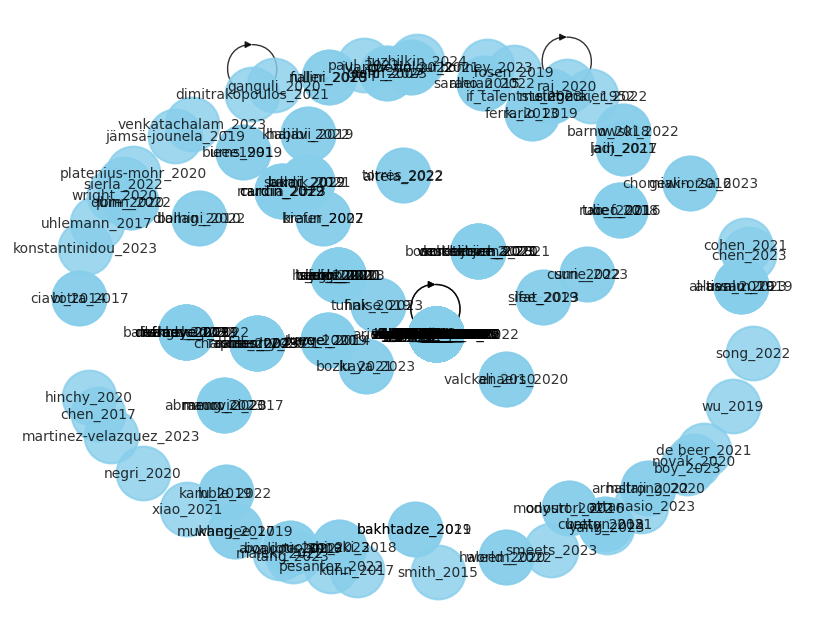

In [142]:
# Get the degree of each node
degree_dict = dict(G.degree(G.nodes()))

# Sort nodes by degree
sorted_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)

# Get the top 40 nodes
top_nodes = [node for node, degree in sorted_nodes[:300]]

# Create a subgraph with these nodes
G_sub = G.subgraph(top_nodes)

# Use kamada_kawai_layout to position nodes
pos = nx.kamada_kawai_layout(G_sub)

# Plot the subgraph
plt.figure(figsize=(8, 6))
nx.draw(G_sub, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_color='k', font_size=10, alpha=0.8, linewidths=1.5)
plt.show()



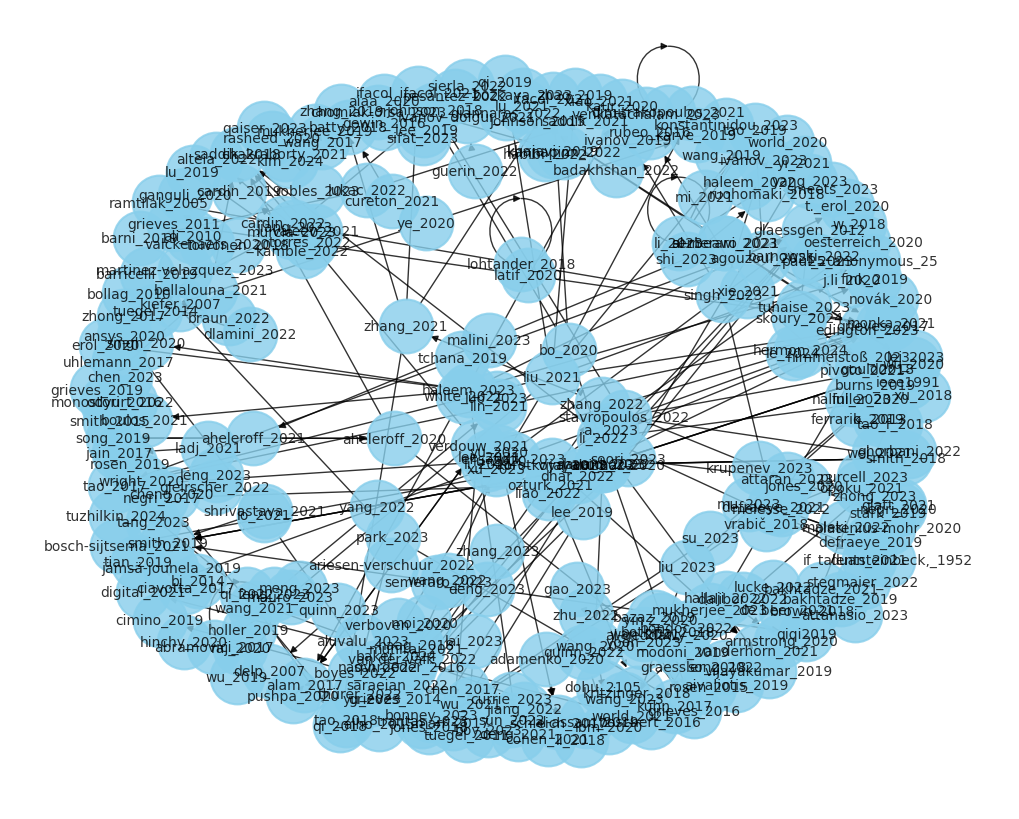

In [143]:
# Use spring_layout to position nodes
pos = nx.spring_layout(G_sub, seed=42)  # Seed for reproducibility

# Plot the subgraph
plt.figure(figsize=(10, 8))
nx.draw(G_sub, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_color='k', font_size=10, alpha=0.8, linewidths=1.5)
plt.show()


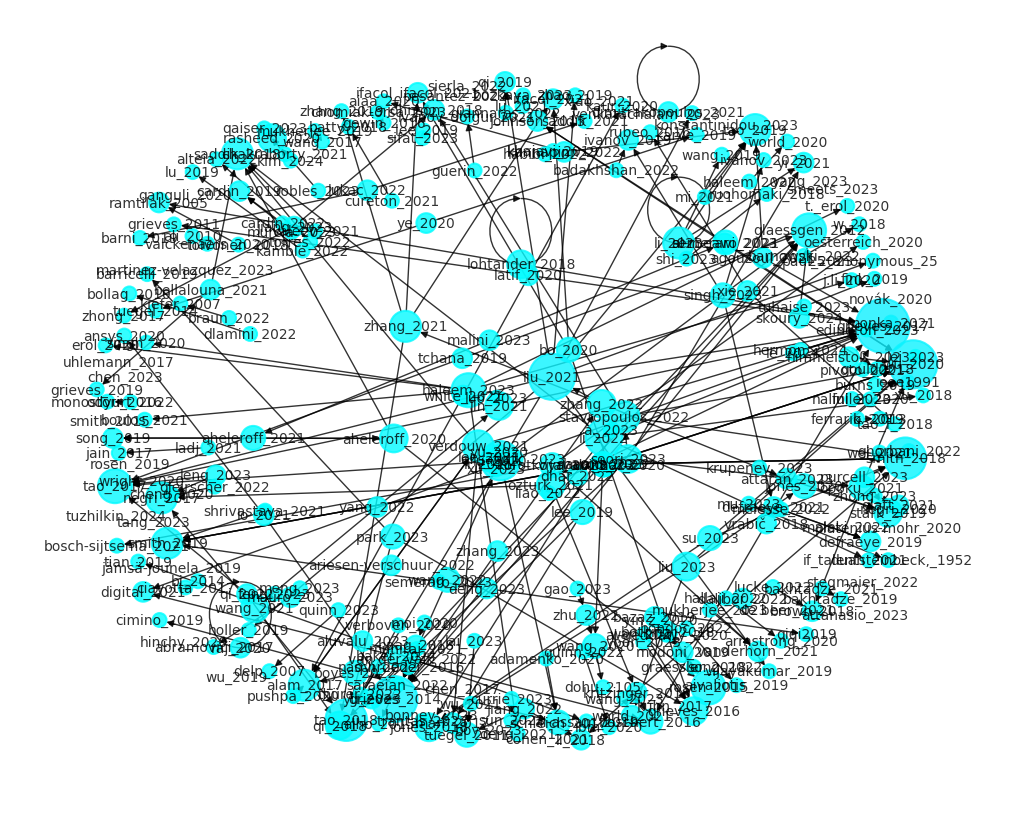

In [144]:
# Get the degree of each node
degree_dict = dict(G_sub.degree())

# Create a list of degrees
degrees = [degree for node, degree in degree_dict.items()]

# Create a colormap based on degree
cmap = plt.cm.cool
colors = [cmap(degree) for degree in degrees]

# Create a list of node sizes based on degree (you can adjust the scaling factor)
sizes = [degree * 100 for degree in degrees]

# Use spring_layout to position nodes
pos = nx.spring_layout(G_sub, seed=42)  # Seed for reproducibility

# Plot the subgraph
plt.figure(figsize=(10, 8))
nx.draw(G_sub, pos, node_color=colors, node_size=sizes, with_labels=True, edge_color='k', font_size=10, alpha=0.8, linewidths=1.5)
plt.show()


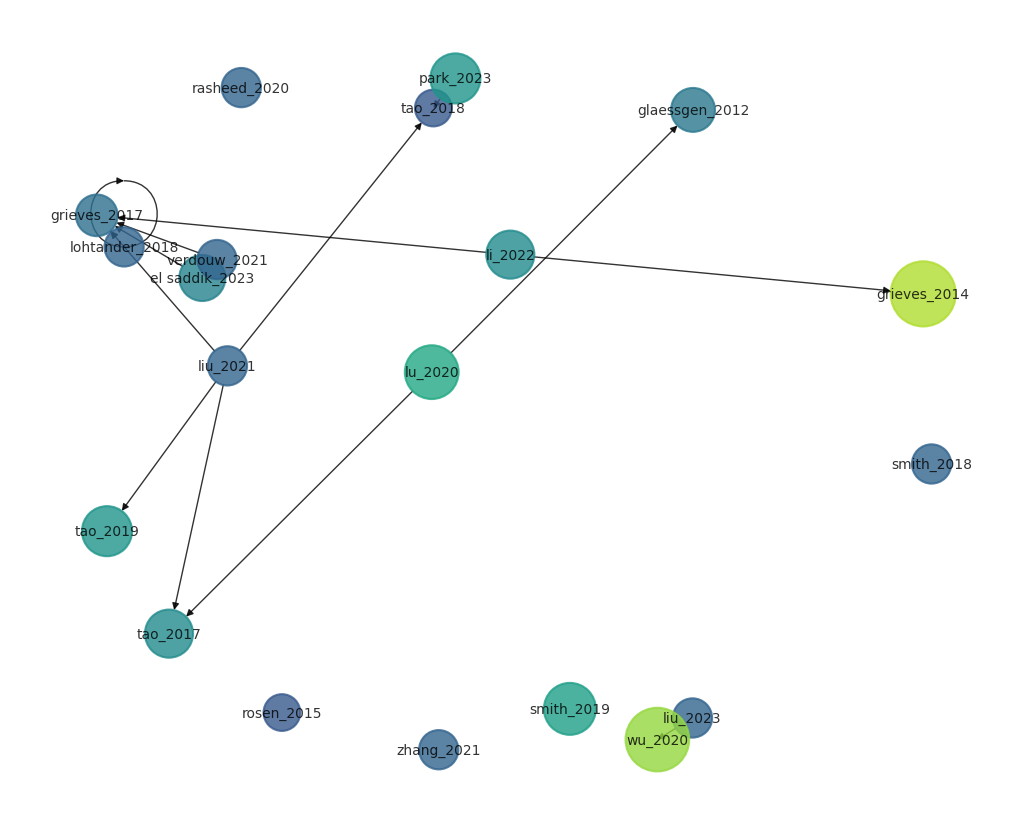

In [183]:
import numpy as np
# Get the degree of each node
degree_dict = dict(G.degree(G.nodes()))

# Sort nodes by degree
sorted_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)

# Get the top 50 nodes
top_nodes = [node for node, degree in sorted_nodes[:20]]

# Create a subgraph with these nodes
G_sub = G.subgraph(top_nodes)

# Use spring_layout to position nodes
pos = nx.spring_layout(G_sub, seed=42)  # Seed for reproducibility

# Create a list of degrees
degrees = [degree for node, degree in degree_dict.items() if node in top_nodes]

# Create a colormap based on degree
cmap = plt.cm.viridis
colors = [cmap(degree/25) for degree in degrees]


# Create a list of node sizes based on degree (you can adjust the scaling factor)
sizes = [degree * 100 for degree in degrees]

# Plot the subgraph
plt.figure(figsize=(10, 8))
nx.draw(G_sub, pos, node_color=colors, node_size=sizes, with_labels=True, edge_color='k', font_size=10, alpha=0.8, linewidths=1.5)
plt.show()


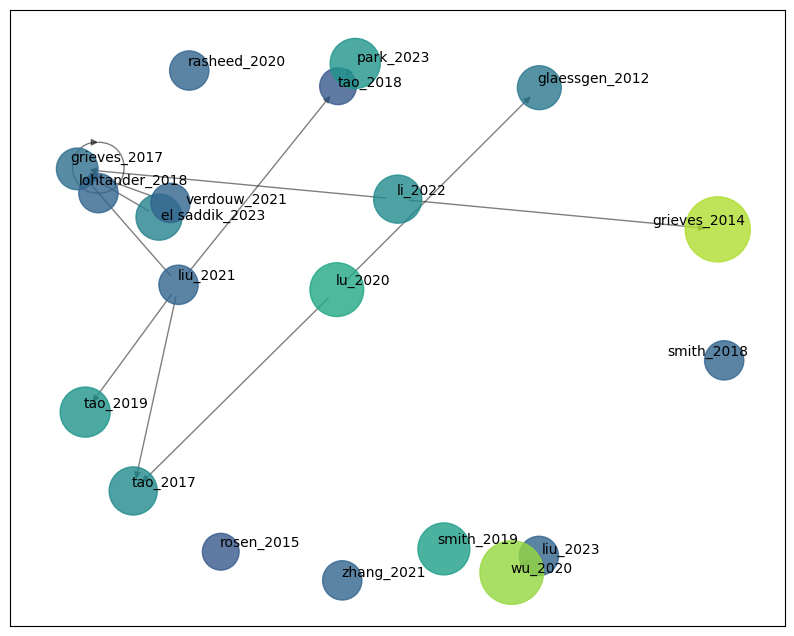

In [184]:

# Create a list to store the text objects
texts = []

plt.figure(figsize=(10, 8))

# Draw the nodes
nx.draw_networkx_nodes(G_sub, pos, node_color=colors, node_size=sizes, alpha=0.8)

# For each node, create a text object and add it to the list
for node, position in pos.items():
    text = plt.text(position[0], position[1], str(node), fontsize=10)
    texts.append(text)

# Adjust the position of text to minimize overlaps
adjust_text(texts)

# Draw the edges
nx.draw_networkx_edges(G_sub, pos, edge_color='k', alpha=0.5)

plt.show()


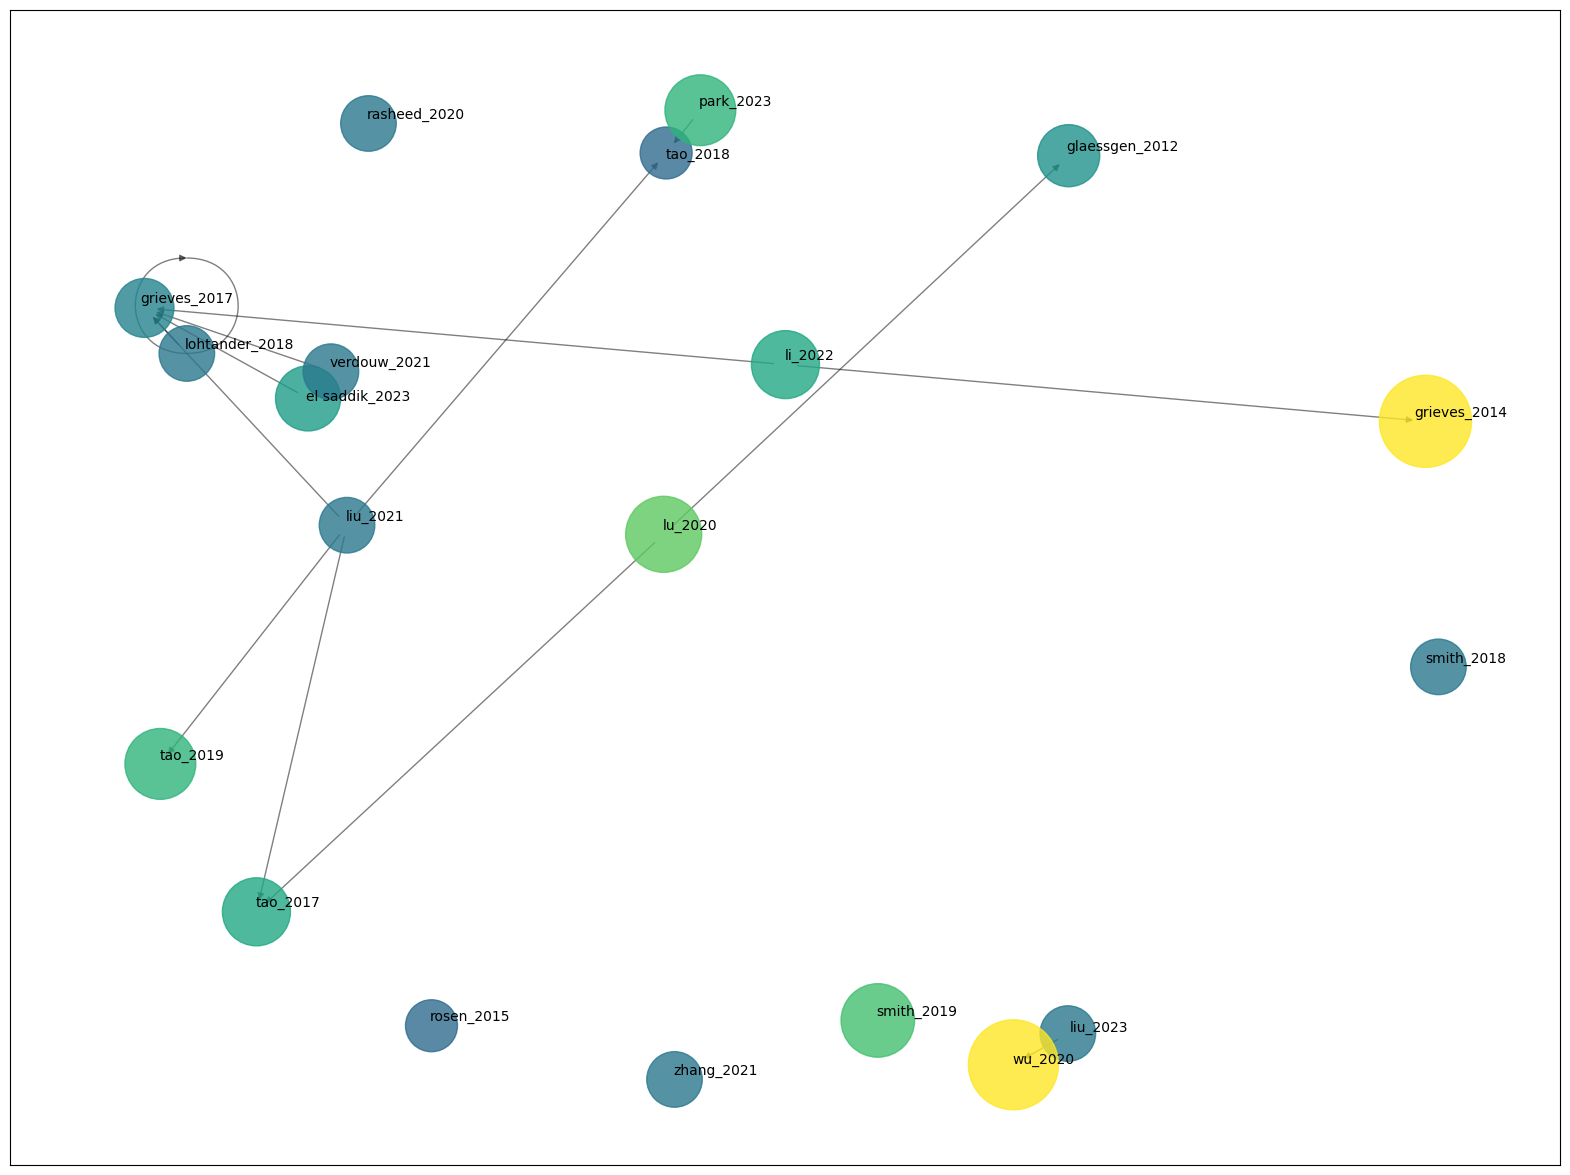

In [185]:
# Increase the scale of the layout
pos = nx.spring_layout(G_sub, scale=5, seed=42)  # Seed for reproducibility

# Increase the scaling factor for node sizes
scaling_factor = 200
min_size = 1
sizes = [max(degree * scaling_factor, min_size) for degree in degrees]  # Increase the scaling factor and set a minimum size


# Create a colormap based on degree
cmap = plt.cm.viridis
colors = [cmap(degree/20) for degree in degrees]


# Create a list to store the text objects
texts = []

plt.figure(figsize=(20, 15))

# Draw the nodes
nx.draw_networkx_nodes(G_sub, pos, node_color=colors, node_size=sizes, alpha=0.8)

# For each node, create a text object and add it to the list
for node, position in pos.items():
    text = plt.text(position[0], position[1], str(node), fontsize=10)
    texts.append(text)

# Adjust the position of text to minimize overlaps
adjust_text(texts)

# Draw the edges
nx.draw_networkx_edges(G_sub, pos, edge_color='k', alpha=0.5)

plt.show()
